# **TIME SERIES FORECASTING (EDA, INITIAL ANALYSIS AND PRE-PROCESSING)**

##### *This model is based on a SQL query. The objective is to predict the quantity of product for the next day for a single product, 3960.*

## Import Libraries

In [835]:
import pandas as pd
import numpy as np
import pymysql
import mysql.connector

import datetime

from meteostat import Point, Daily
import sqlalchemy as sa

from sqlalchemy import create_engine
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

## Database Query

In [836]:
class DatabaseConnection:

    def __init__(self, password,
                 dialect = "mysql",
                 driver = "pymysql",
                 username = " *** ",
                 host = " *** ",
                 port = " *** ",
                 database = " *** "):

        self.__password = password
        connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
        self.engine = sa.create_engine(connection_string)

    def query_to_df(self, query):
        with self.engine.connect() as conn:
            result = conn.execute(query)
            df = pd.DataFrame(result.fetchall(), columns=result.keys())
            return df


query = """
SELECT familia,
articulo,
fechaVenta AS fecha_venta,
festivo,
precio,
cantidad,
importe,
orden_articulo_familia

FROM ventas_diarias_estudio
"""

database = DatabaseConnection(" *** ")

ventas = database.query_to_df(query)
ventas.head()

familia articulo fecha_venta festivo  precio  cantidad     importe  \
0  BOLLERIA     3960  2021-05-18    None   2.318     216.0  500.688008   
1  BOLLERIA     6286  2021-08-29    None   3.136      99.0  310.464005   
2  BOLLERIA     3880  2021-09-21    None   3.000     102.0  306.000000   
3  BOLLERIA     5803  2021-10-21    None   3.000      42.0  126.000000   
4  BOLLERIA     3880  2021-12-07    None   3.000     141.0  423.000000   

   orden_articulo_familia  
0                       1  
1                       4  
2                       3  
3                       5  
4                       3

In [837]:
ventas = (
           ventas.assign(fecha_venta = pd.to_datetime(ventas["fecha_venta"]))
                 .astype({"articulo": int})
        )

ventas.head()

familia  articulo fecha_venta festivo  precio  cantidad     importe  \
0  BOLLERIA      3960  2021-05-18    None   2.318     216.0  500.688008   
1  BOLLERIA      6286  2021-08-29    None   3.136      99.0  310.464005   
2  BOLLERIA      3880  2021-09-21    None   3.000     102.0  306.000000   
3  BOLLERIA      5803  2021-10-21    None   3.000      42.0  126.000000   
4  BOLLERIA      3880  2021-12-07    None   3.000     141.0  423.000000   

   orden_articulo_familia  
0                       1  
1                       4  
2                       3  
3                       5  
4                       3

## API Connection [Meteostat API](https://dev.meteostat.net/python/daily.html)

Variables:

- **tavg** -> The average air temperature in °C
- **tmin** -> The minimum air temperature in °C
- **tmax** -> The maximum air temperature in °C
- **prcp** -> The daily precipitation total in mm
- **wdir** -> The average wind direction in degrees (°)
- **wspd** -> The average wind speed in km/h
- **pres** -> The average sea-level air pressure in hPa

In [838]:
class DailyWeatherData:

    # Shop location
    ECHEVERRIA_SHOP = Point(36.709758, -4.462520)

    # Important columns
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Definition of the time horizon
    def __init__(self, start, end = datetime.datetime.now()):
        self.start = start
        self.end = end

    # It is established that consultation is daily
    def get_weather_data(self):
        daily_data = Daily(self.ECHEVERRIA_SHOP, self.start, self.end)
        data = daily_data.fetch() #recovers data
        return data[self.IMP_COLUMNS].add_suffix('_w').reset_index()

In [839]:
start = ventas["fecha_venta"].min()

end = ventas["fecha_venta"].max()

weather_query = DailyWeatherData(start, end)

weather = weather_query.get_weather_data()

weather.head()

time  tavg_w  tmin_w  tmax_w  prcp_w  wdir_w  wspd_w  pres_w
0 2021-05-01    17.2    11.9    22.8     0.0   282.0    14.2  1014.0
1 2021-05-02    16.3    10.8    23.2     0.0   233.0    15.7  1015.9
2 2021-05-03    15.3    12.7    20.1     6.5   272.0     9.7  1017.7
3 2021-05-04    16.5    12.0    20.9     0.0   206.0    12.1  1018.0
4 2021-05-05    16.7    12.3    21.7     0.0   132.0    13.8  1016.5

## Merge of Sales and Weather to create Final Dataframe

In [840]:
df = pd.merge(ventas, weather,
              left_on=["fecha_venta"], right_on=["time"],
              how="inner").drop("time", axis=1)

# Order the dataframe
df.sort_values(["articulo", "fecha_venta"], inplace = True)

df.head(5)

familia  articulo fecha_venta          festivo  precio  cantidad  \
8460   PANADERIA       417  2021-05-01             None   4.038      72.0   
436    PANADERIA       417  2021-05-02  Día de la Madre   4.038      81.0   
1758   PANADERIA       417  2021-05-03   Día de la Cruz   4.038      90.0   
5867   PANADERIA       417  2021-05-04             None   4.038      84.0   
10022  PANADERIA       417  2021-05-05             None   4.038      84.0   

          importe  orden_articulo_familia  tavg_w  tmin_w  tmax_w  prcp_w  \
8460   290.736004                       5    17.2    11.9    22.8     0.0   
436    327.077995                       5    16.3    10.8    23.2     0.0   
1758   363.419998                       5    15.3    12.7    20.1     6.5   
5867   339.192001                       5    16.5    12.0    20.9     0.0   
10022  339.192003                       5    16.7    12.3    21.7     0.0   

       wdir_w  wspd_w  pres_w  
8460    282.0    14.2  1014.0  
436     233.0    15.7  1015.9  
1758    272.0     9.7  1017.7  
5867    206.0    12.1  1018.0  
10022   132.0    13.8  1016.5

## **EDA**

### 1. Initial inspection

In [841]:
df.describe(include='all')

familia      articulo                    fecha_venta  \
count       10322  10322.000000                          10322   
unique          3           NaN                            NaN   
top     PANADERIA           NaN                            NaN   
freq         3650           NaN                            NaN   
mean          NaN   3945.385197  2022-04-29 14:56:20.275140608   
min           NaN    417.000000            2021-05-01 00:00:00   
25%           NaN   1043.000000            2021-10-28 00:00:00   
50%           NaN   5403.000000            2022-04-29 00:00:00   
75%           NaN   6286.000000            2022-10-29 00:00:00   
max           NaN   6549.000000            2023-04-30 00:00:00   
std           NaN   2404.409766                            NaN   

                festivo        precio      cantidad       importe  \
count               809  10322.000000  10322.000000  10322.000000   
unique               26           NaN           NaN           NaN   
top     Feria de Málaga           NaN           NaN           NaN   
freq                 99           NaN           NaN           NaN   
mean                NaN     15.398333    138.310118    462.617803   
min                 NaN      0.865000      1.200000      9.000000   
25%                 NaN      2.591000     15.000000    288.000000   
50%                 NaN      3.545000     84.000000    405.059754   
75%                 NaN     34.091000    219.000000    569.453926   
max                 NaN     43.500000   1110.000000   3271.929962   
std                 NaN     16.987621    148.941152    273.939861   

        orden_articulo_familia        tavg_w        tmin_w        tmax_w  \
count             10322.000000  10322.000000  10322.000000  10322.000000   
unique                     NaN           NaN           NaN           NaN   
top                        NaN           NaN           NaN           NaN   
freq                       NaN           NaN           NaN           NaN   
mean                  2.961538     19.373164     15.195786     24.894371   
min                   1.000000      7.300000      1.100000     13.300000   
25%                   2.000000     14.500000     10.800000     19.600000   
50%                   3.000000     19.300000     14.600000     24.700000   
75%                   4.000000     23.900000     20.100000     29.600000   
max                   5.000000     33.500000     27.500000     42.600000   
std                   1.395584      5.406506      5.565703      5.991496   

              prcp_w        wdir_w        wspd_w        pres_w  
count   10322.000000  10292.000000  10292.000000  10292.000000  
unique           NaN           NaN           NaN           NaN  
top              NaN           NaN           NaN           NaN  
freq             NaN           NaN           NaN           NaN  
mean        0.781447    216.693743     14.346444   1018.053916  
min         0.000000     10.000000      6.000000   1004.400000  
25%         0.000000    144.000000     10.900000   1014.500000  
50%         0.000000    245.000000     12.500000   1017.300000  
75%         0.000000    284.000000     16.900000   1021.000000  
max        46.800000    356.000000     46.500000   1032.800000  
std         4.285807     73.500826      5.356983      5.164614

In [842]:
(
  df.dtypes.to_frame("Tipo")
    .assign(Cardinalidad = df.nunique())
    .assign(Granularidad = df.nunique() / len(df) * 100)
    .assign(Nulos_Pct = df.isnull().sum() / len(df) * 100)
    .assign(Max = df.dropna().apply(min))
    .assign(Min = df.dropna().apply(max))
    .sort_values(["Tipo"])
)

Tipo  Cardinalidad  Granularidad  Nulos_Pct  \
articulo                         int64            15      0.145321   0.000000   
fecha_venta             datetime64[ns]           730      7.072273   0.000000   
orden_articulo_familia           int64             5      0.048440   0.000000   
precio                         float64            45      0.435962   0.000000   
cantidad                       float64          1388     13.447006   0.000000   
importe                        float64          6171     59.784925   0.000000   
tavg_w                         float64           200      1.937609   0.000000   
tmin_w                         float64           212      2.053866   0.000000   
tmax_w                         float64           220      2.131370   0.000000   
prcp_w                         float64            58      0.561907   0.000000   
wdir_w                         float64           225      2.179810   0.290641   
wspd_w                         float64           198      1.918233   0.290641   
pres_w                         float64           218      2.111994   0.290641   
familia                         object             3      0.029064   0.000000   
festivo                         object            26      0.251889  92.162372   

                                        Max                  Min  
articulo                                417                 6549  
fecha_venta             2021-05-02 00:00:00  2023-04-09 00:00:00  
orden_articulo_familia                    1                    5  
precio                                0.865                 43.5  
cantidad                                3.0                966.0  
importe                           85.080002          2377.851974  
tavg_w                                 11.1                 31.1  
tmin_w                                  5.2                 26.3  
tmax_w                                 15.0                 39.2  
prcp_w                                  0.0                 24.1  
wdir_w                                119.0                356.0  
wspd_w                                  6.1                 28.0  
pres_w                               1008.9               1029.3  
familia                            BOLLERIA           PASTELERIA  
festivo                           Año Nuevo        Viernes Santo

<Axes: >

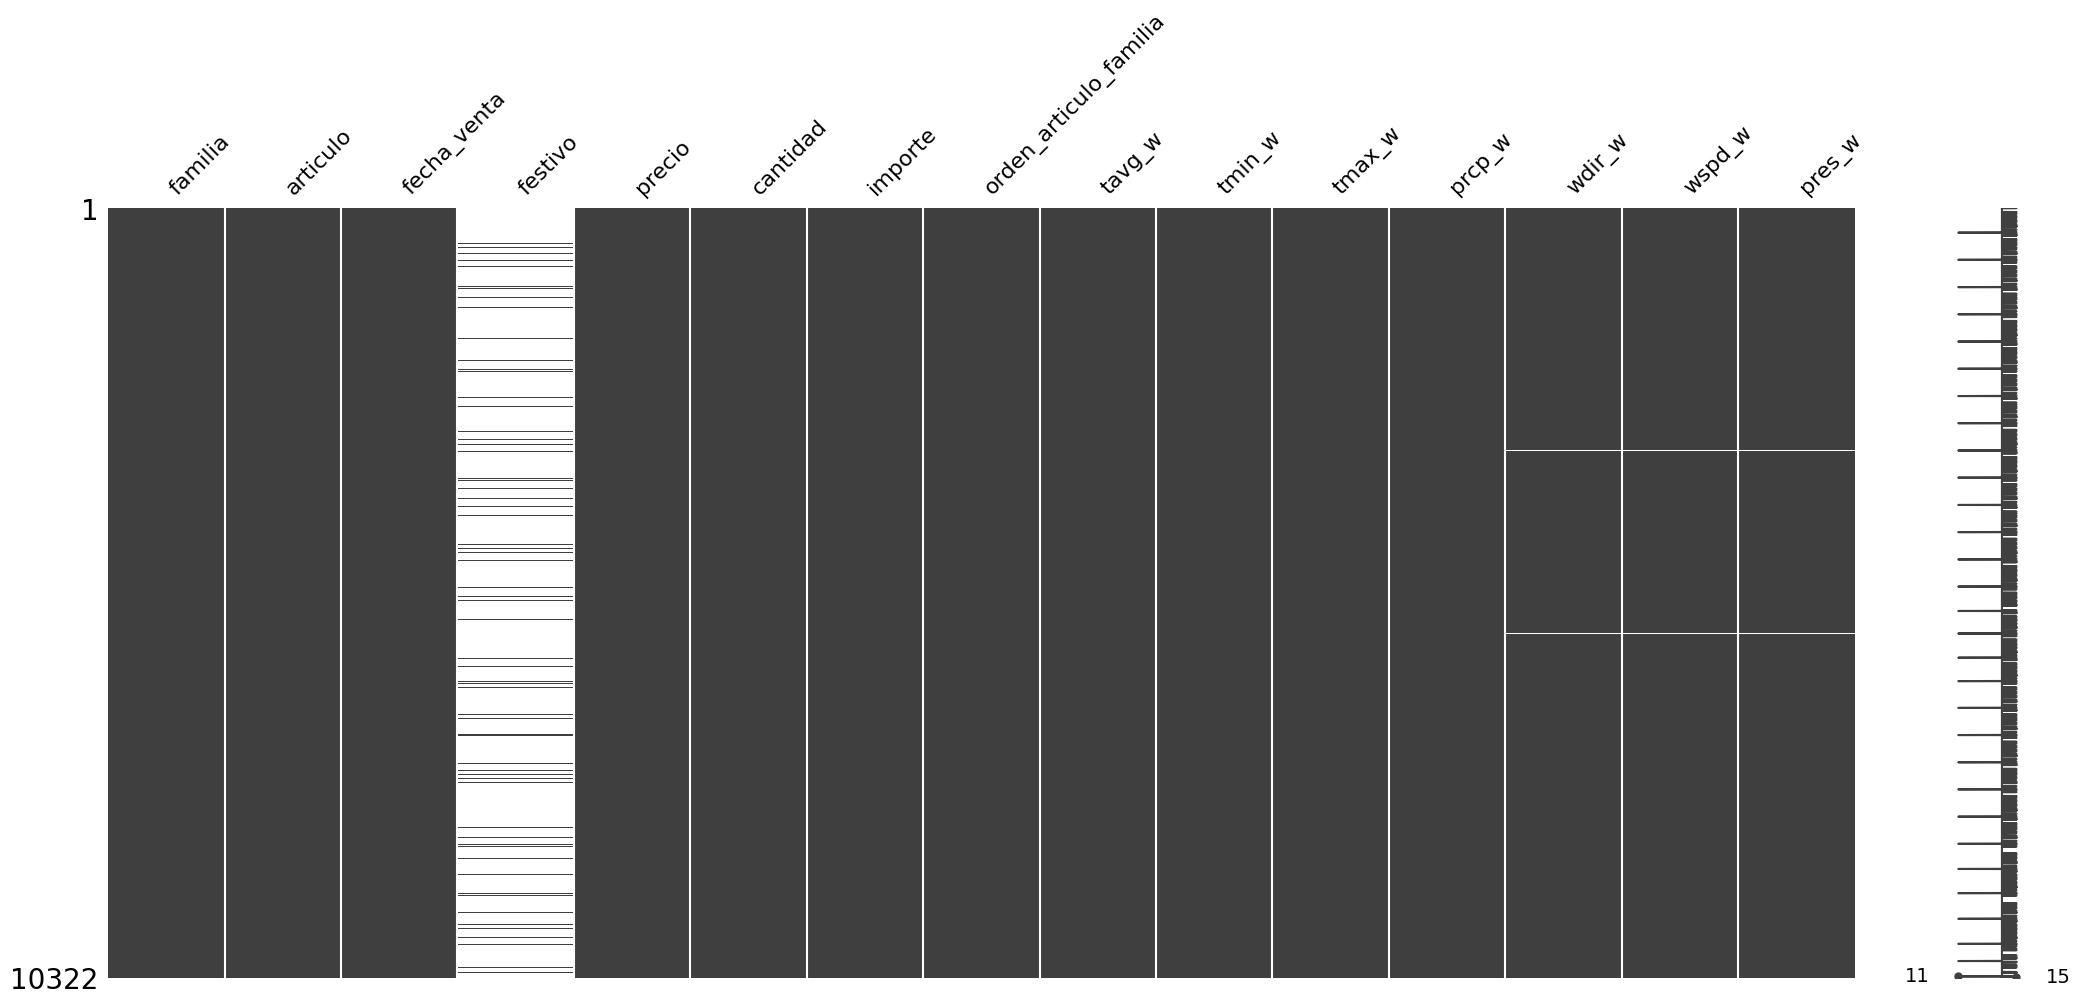

In [843]:
msno.matrix(df)

In [844]:
df[df.duplicated(['fecha_venta', 'articulo'], keep=False)]
df.drop_duplicates(['fecha_venta', 'articulo'])

familia  articulo fecha_venta          festivo  precio  cantidad  \
8460    PANADERIA       417  2021-05-01             None   4.038      72.0   
436     PANADERIA       417  2021-05-02  Día de la Madre   4.038      81.0   
1758    PANADERIA       417  2021-05-03   Día de la Cruz   4.038      90.0   
5867    PANADERIA       417  2021-05-04             None   4.038      84.0   
10022   PANADERIA       417  2021-05-05             None   4.038      84.0   
...           ...       ...         ...              ...     ...       ...   
3430   PASTELERIA      6549  2023-04-24             None  32.591       9.0   
3251   PASTELERIA      6549  2023-04-25             None  32.591       3.0   
5994   PASTELERIA      6549  2023-04-28             None  32.591      21.0   
4812   PASTELERIA      6549  2023-04-29             None  32.591       6.0   
6223   PASTELERIA      6549  2023-04-30             None  32.591      27.0   

          importe  orden_articulo_familia  tavg_w  tmin_w  tmax_w  prcp_w  \
8460   290.736004                       5    17.2    11.9    22.8     0.0   
436    327.077995                       5    16.3    10.8    23.2     0.0   
1758   363.419998                       5    15.3    12.7    20.1     6.5   
5867   339.192001                       5    16.5    12.0    20.9     0.0   
10022  339.192003                       5    16.7    12.3    21.7     0.0   
...           ...                     ...     ...     ...     ...     ...   
3430   293.319008                       5    18.4    13.7    25.5     0.0   
3251    97.773003                       5    19.4    14.0    28.3     0.0   
5994   684.411018                       5    20.8    16.6    26.7     0.0   
4812   195.546005                       5    25.6    18.7    34.3     0.0   
6223   879.957016                       5    23.1    18.2    27.7     0.0   

       wdir_w  wspd_w  pres_w  
8460    282.0    14.2  1014.0  
436     233.0    15.7  1015.9  
1758    272.0     9.7  1017.7  
5867    206.0    12.1  1018.0  
10022   132.0    13.8  1016.5  
...       ...     ...     ...  
3430    140.0    11.1  1015.5  
3251    353.0    11.8  1015.5  
5994    144.0    14.3  1015.2  
4812    289.0    16.9  1015.4  
6223    239.0    15.3  1014.9  

[10322 rows x 15 columns]

In [845]:
min_date = df['fecha_venta'].min()
max_date = df['fecha_venta'].max()

print(f"The dataset contains values from {min_date} to {max_date}. ",
      f"Total {max_date - min_date}")

The dataset contains values from 2021-05-01 00:00:00 to 2023-04-30 00:00:00.  Total 729 days 00:00:00


In [846]:
unique_articles = df.sort_values("familia")["articulo"].unique().tolist()
complete_range = pd.date_range(start=min_date, end=max_date, freq='D')

for article in unique_articles:

    subset = df.query("articulo == @article")
    family = subset["familia"].unique().tolist()[0]

    missing_dates = complete_range.difference(subset['fecha_venta'])

    print(family, "-> Articulo", article, "-> Fechas faltantes", len(missing_dates))

BOLLERIA -> Articulo 3960 -> Fechas faltantes 0
BOLLERIA -> Articulo 5803 -> Fechas faltantes 3
BOLLERIA -> Articulo 3880 -> Fechas faltantes 0
BOLLERIA -> Articulo 6286 -> Fechas faltantes 2
BOLLERIA -> Articulo 6425 -> Fechas faltantes 1
PANADERIA -> Articulo 1084 -> Fechas faltantes 0
PANADERIA -> Articulo 417 -> Fechas faltantes 0
PANADERIA -> Articulo 900 -> Fechas faltantes 0
PANADERIA -> Articulo 968 -> Fechas faltantes 0
PANADERIA -> Articulo 1043 -> Fechas faltantes 0
PASTELERIA -> Articulo 6451 -> Fechas faltantes 73
PASTELERIA -> Articulo 6549 -> Fechas faltantes 304
PASTELERIA -> Articulo 6523 -> Fechas faltantes 48
PASTELERIA -> Articulo 5403 -> Fechas faltantes 103
PASTELERIA -> Articulo 5404 -> Fechas faltantes 94


In [847]:
articulo = 3960
filtered_df = (
    df.query("articulo == @articulo")
      .set_index("fecha_venta")
      .reindex(complete_range)
)

filtered_df["articulo"] = filtered_df["articulo"].fillna(method='ffill')

fig = px.line(filtered_df, x=filtered_df.index, y="cantidad", color="articulo")
fig.show()

/tmp/ipykernel_2129/3284070909.py:8: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [848]:
articulo = 5403
filtered_df = (
    df.query("articulo == @articulo")
      .set_index("fecha_venta")
      .reindex(complete_range)
)

filtered_df["articulo"] = filtered_df["articulo"].fillna(method='ffill')

fig = px.line(filtered_df, x=filtered_df.index, y="cantidad", color="articulo")
fig.show()

/tmp/ipykernel_2129/4153907290.py:8: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [849]:
unique_articles = df.sort_values("familia")["articulo"].unique().tolist()

for article in unique_articles:

    subset = df.query("articulo == @article")
    family = subset["familia"].unique().tolist()[0]

    Q1 = subset['cantidad'].quantile(0.25)
    Q3 = subset['cantidad'].quantile(0.75)
    IQR = Q3 - Q1

    outliers = subset[(subset['cantidad'] < (Q1 - 1.5 * IQR)) | (subset['cantidad'] > (Q3 + 1.5 * IQR))]

    print(family, "-> Articulo", article, "-> Outliers", len(outliers["cantidad"]))

BOLLERIA -> Articulo 3960 -> Outliers 15
BOLLERIA -> Articulo 5803 -> Outliers 52
BOLLERIA -> Articulo 3880 -> Outliers 36
BOLLERIA -> Articulo 6286 -> Outliers 57
BOLLERIA -> Articulo 6425 -> Outliers 25
PANADERIA -> Articulo 1084 -> Outliers 6
PANADERIA -> Articulo 417 -> Outliers 19
PANADERIA -> Articulo 900 -> Outliers 31
PANADERIA -> Articulo 968 -> Outliers 27
PANADERIA -> Articulo 1043 -> Outliers 38
PASTELERIA -> Articulo 6451 -> Outliers 22
PASTELERIA -> Articulo 6549 -> Outliers 3
PASTELERIA -> Articulo 6523 -> Outliers 35
PASTELERIA -> Articulo 5403 -> Outliers 38
PASTELERIA -> Articulo 5404 -> Outliers 25


In [850]:
outliers.head()

familia  articulo fecha_venta          festivo     precio   cantidad  \
806   PASTELERIA      5404  2021-05-02  Día de la Madre  39.544998  46.710000   
4386  PASTELERIA      5404  2021-05-15             None  39.544998  46.950001   
7686  PASTELERIA      5404  2021-05-22             None  39.544998  53.700000   
1036  PASTELERIA      5404  2021-06-05             None  39.544998  43.650001   
4485  PASTELERIA      5404  2021-06-26             None  39.544998  45.150000   

          importe  orden_articulo_familia  tavg_w  tmin_w  tmax_w  prcp_w  \
806   1847.148033                       1    16.3    10.8    23.2     0.0   
4386  1856.639038                       1    19.4    14.5    24.7     0.0   
7686  2123.570007                       1    23.6    17.4    32.5     0.0   
1036  1726.144005                       1    21.2    19.0    24.3     0.9   
4485  1785.457977                       1    22.8    18.3    28.7     0.0   

      wdir_w  wspd_w  pres_w  
806    233.0    15.7  1015.9  
4386   112.0    13.9  1016.1  
7686   295.0    19.4  1011.8  
1036   181.0    10.4  1021.1  
4485   140.0    14.7  1016.9

### 2. Analysis of the variable to be predicted

In [851]:
group = df.groupby(pd.Grouper(key="fecha_venta", freq="1D"))["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad")
fig.show()

In [852]:
group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad", color="familia")
fig.show()

In [853]:
scaler = MinMaxScaler()

def normalize(column):
    return scaler.fit_transform(column.values.reshape(-1, 1)).flatten()

group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
group['cantidad'] = group.groupby('familia')['cantidad'].transform(normalize)
fig = px.line(group, x="fecha_venta", y="cantidad", color="familia")
fig.show()

In [854]:
group = df.groupby(["articulo", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad", color="articulo")
fig.show()

In [855]:
# Check if the process is stationary

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32m Stationary \u001b[0m")
    else:
        print("\x1b[31m Non-stationary \x1b[0m")

group = df.groupby([pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
check_stationarity(group["cantidad"])
fig = px.line(group, x="fecha_venta", y="cantidad")
fig.show()

ADF Statistic:  -1.4639255514154315
p-value:  0.5512754434013823
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
 Non-stationary 


In [856]:
# Taking the first difference
# We can take the first difference to see if our series becomes stationary.
# This removes trends and stabilises the variance of the series, allowing it to be modelled.

group["cantidad_diff"] = group["cantidad"].diff().fillna(0)
check_stationarity(group["cantidad_diff"])

ADF Statistic:  -12.370069834810995
p-value:  5.305870413780951e-23
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
 Stationary 


In [857]:
fig = px.line(group, x="fecha_venta", y="cantidad_diff")
fig.show()

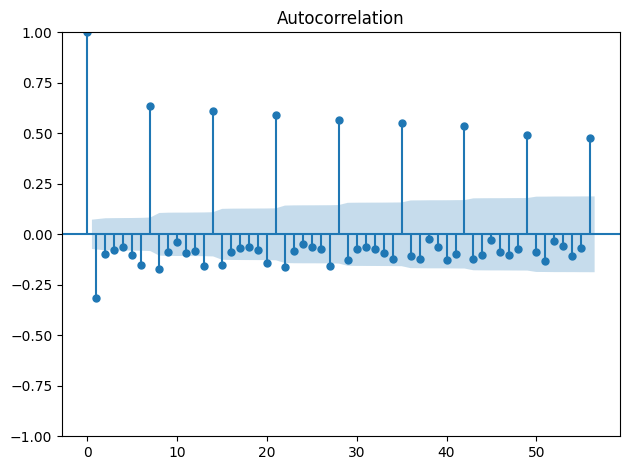

In [858]:
# Autocorrelation analysis
# In general terms, this graph indicates that a quantity value is directly related to its previous quantity value and last week's quantity value.
# directly related to its previous quantity value and last week's quantity value.
# It appears that there is weekly seasonality.

plot_acf(group["cantidad_diff"],lags=56)
plt.tight_layout()
plt.show()

In [859]:
df["weekofyear"] = df["fecha_venta"].dt.isocalendar().week
df["monthofyear"] = df["fecha_venta"].dt.month

# Día de la semana, del mes y del año
df["dayofweek"] = df["fecha_venta"].dt.day_of_week #Lunes 0 y Domingo 6
df["dayofmonth"] = df["fecha_venta"].dt.day
df["dayofyear"] = df["fecha_venta"].dt.dayofyear

def graph_by_freq(freq, breakdown="familia", norm=False):
    group = df.groupby([breakdown, freq], as_index=False)["cantidad"].sum()

    if norm == True:
        group['cantidad'] = group.groupby(breakdown)['cantidad'].transform(normalize)

    fig = px.line(group, x=freq, y="cantidad", color=breakdown, markers=True)
    fig.show()

graph_by_freq("dayofweek")

# As we found in our autocorrelation analysis
# the quantity values could have a relationship with their value from last week
# because there is a weekly buying pattern that repeats over time

In [860]:
graph_by_freq("dayofweek", "articulo")

In [861]:
fig = px.box(df, x="dayofweek", y="cantidad", color='familia')
fig.show()

In [862]:
graph_by_freq("monthofyear")

### 3. Analysis of the variable to be predicted versus the rest of the variables

In [863]:
# 1 if it is a public holiday, 0 if it is not a holiday
df['es_festivo'] = df['festivo'].apply(lambda x: 0 if x is None else 1)

fig = px.box(df, x="es_festivo", y="cantidad", color='familia')
fig.show()

# Holiday shopping behaviour appears to be slightly higher

In [864]:
df.drop(columns=["es_festivo"], inplace=True)

In [865]:
# 1 if it rains, 0 if it doesn't rain
df["lluvia"] = np.where(df["prcp_w"] > 0, 1, 0) #i el valor en la columna "prcp_w" es mayor que 0, se asigna el valor 1, sino el valor 0

fig = px.box(df, x="lluvia", y="cantidad", color='familia')
fig.show()

# It seems that rain is not a deterrent to purchase

In [866]:
df.drop(columns=["lluvia"], inplace=True)

In [867]:
labels_tavg = ['Temperatura muy baja',
               'Temperatura baja',
               'Temperatura normal',
               'Temperatura alta',
               'Temperatura muy alta']

df['quintiles_tavg_w'] = pd.qcut(df['tavg_w'], q=5, labels=labels_tavg)

group = df.groupby(["familia", "quintiles_tavg_w"])["cantidad"].sum().reset_index()
fig = px.bar(group, x='quintiles_tavg_w', y='cantidad', color="familia",barmode='group')
fig.show()

/tmp/ipykernel_2129/1751443749.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [868]:
def function_variations(x):
    list_unique = x.unique()
    len_list = len(list_unique)

    if len_list > 1:
        return 1
    else:
        return 0

group = df.groupby(["articulo",
                    pd.Grouper(key="fecha_venta", freq="1M"),
                    "familia"]).agg({"cantidad": "sum",
                                     "precio": function_variations}).reset_index()

group["precio"] = group.groupby("articulo")["precio"].transform("cumsum")
group["precio"] = group["precio"].astype(object)

fig = px.box(group, x="precio", y="cantidad", color='articulo')
fig.show()

/tmp/ipykernel_2129/21141459.py:11: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [869]:
df.drop(columns=["weekofyear"], inplace=True)
df.drop(columns=["monthofyear"], inplace=True)
df.drop(columns=["dayofweek"], inplace=True)
df.drop(columns=["dayofmonth"], inplace=True)
df.drop(columns=["quintiles_tavg_w"], inplace=True)
df.drop(columns=["dayofyear"], inplace=True)

## Modelling

* Which variable do I want to predict? **Product sales**

* What time window do I want to predict?
**I want to predict the next day's sales**

* How often is my database updated with new data?
**For this I need the information to be updated frequently, assuming we are going to have it every day**

* How long does my model take to train? **Important to keep in mind** 

* What days influence my model the most? **Take into account holidays, weather, etc**

* What pattern is usually repeated? **Sundays, for example, are likely to have more sales than other days.** 
**It is very common to make a predictive model for the first four days of the week, and another predictive model for Friday, Saturday, and Sunday** 

* Which exogenous variables are the most influential?
**Calendar and weather**

In [870]:
df.head()

familia  articulo fecha_venta          festivo  precio  cantidad  \
8460   PANADERIA       417  2021-05-01             None   4.038      72.0   
436    PANADERIA       417  2021-05-02  Día de la Madre   4.038      81.0   
1758   PANADERIA       417  2021-05-03   Día de la Cruz   4.038      90.0   
5867   PANADERIA       417  2021-05-04             None   4.038      84.0   
10022  PANADERIA       417  2021-05-05             None   4.038      84.0   

          importe  orden_articulo_familia  tavg_w  tmin_w  tmax_w  prcp_w  \
8460   290.736004                       5    17.2    11.9    22.8     0.0   
436    327.077995                       5    16.3    10.8    23.2     0.0   
1758   363.419998                       5    15.3    12.7    20.1     6.5   
5867   339.192001                       5    16.5    12.0    20.9     0.0   
10022  339.192003                       5    16.7    12.3    21.7     0.0   

       wdir_w  wspd_w  pres_w  
8460    282.0    14.2  1014.0  
436     233.0    15.7  1015.9  
1758    272.0     9.7  1017.7  
5867    206.0    12.1  1018.0  
10022   132.0    13.8  1016.5

## **Initial Analysis**

#### I select only article 3960 of the Viennese pastry family

In [871]:
df[["familia", "articulo"]].drop_duplicates().sort_values("familia").reset_index(drop=True)

familia  articulo
0     BOLLERIA      3880
1     BOLLERIA      3960
2     BOLLERIA      5803
3     BOLLERIA      6286
4     BOLLERIA      6425
5    PANADERIA       417
6    PANADERIA       900
7    PANADERIA       968
8    PANADERIA      1043
9    PANADERIA      1084
10  PASTELERIA      5403
11  PASTELERIA      5404
12  PASTELERIA      6451
13  PASTELERIA      6523
14  PASTELERIA      6549

In [872]:
family = "BOLLERIA"
item = 3960

itemdata = df.loc[((df["familia"]==family)&(df["articulo"]==item))].reset_index(drop=True).copy()
itemdata["fecha_venta"] = pd.to_datetime(itemdata["fecha_venta"])
itemdata.sort_values("fecha_venta", ascending=True, inplace=True)
itemdata.head()

familia  articulo fecha_venta          festivo  precio  cantidad  \
0  BOLLERIA      3960  2021-05-01             None   2.318     402.0   
1  BOLLERIA      3960  2021-05-02  Día de la Madre   2.318     369.0   
2  BOLLERIA      3960  2021-05-03   Día de la Cruz   2.318     228.0   
3  BOLLERIA      3960  2021-05-04             None   2.318     237.0   
4  BOLLERIA      3960  2021-05-05             None   2.318     288.0   

      importe  orden_articulo_familia  tavg_w  tmin_w  tmax_w  prcp_w  wdir_w  \
0  931.835995                       1    17.2    11.9    22.8     0.0   282.0   
1  855.341996                       1    16.3    10.8    23.2     0.0   233.0   
2  528.503994                       1    15.3    12.7    20.1     6.5   272.0   
3  549.365999                       1    16.5    12.0    20.9     0.0   206.0   
4  667.584000                       1    16.7    12.3    21.7     0.0   132.0   

   wspd_w  pres_w  
0    14.2  1014.0  
1    15.7  1015.9  
2     9.7  1017.7  
3    12.1  1018.0  
4    13.8  1016.5

#### I eliminate variables that are not significant

In [873]:
itemdata.columns

Index(['familia', 'articulo', 'fecha_venta', 'festivo', 'precio', 'cantidad',
       'importe', 'orden_articulo_familia', 'tavg_w', 'tmin_w', 'tmax_w',
       'prcp_w', 'wdir_w', 'wspd_w', 'pres_w'],
      dtype='object')

- Family

In [874]:
itemdata["familia"].unique()

array(['BOLLERIA'], dtype=object)

In [875]:
itemdata.drop(columns=["familia"], inplace=True)

- Order Article

In [876]:
itemdata["orden_articulo_familia"].unique()

array([1])

In [877]:
itemdata.drop(columns=["orden_articulo_familia"], inplace=True)

- Article

In [878]:
itemdata["articulo"].unique()

array([3960])

In [879]:
itemdata.drop(columns=["articulo"], inplace=True)

#### New Boolean columns

In [880]:
itemdata["lluvia"] = np.where(itemdata["prcp_w"]>0,1,0) #mayor que 0, true = 1, false = 0
itemdata.head()

fecha_venta          festivo  precio  cantidad     importe  tavg_w  tmin_w  \
0  2021-05-01             None   2.318     402.0  931.835995    17.2    11.9   
1  2021-05-02  Día de la Madre   2.318     369.0  855.341996    16.3    10.8   
2  2021-05-03   Día de la Cruz   2.318     228.0  528.503994    15.3    12.7   
3  2021-05-04             None   2.318     237.0  549.365999    16.5    12.0   
4  2021-05-05             None   2.318     288.0  667.584000    16.7    12.3   

   tmax_w  prcp_w  wdir_w  wspd_w  pres_w  lluvia  
0    22.8     0.0   282.0    14.2  1014.0       0  
1    23.2     0.0   233.0    15.7  1015.9       0  
2    20.1     6.5   272.0     9.7  1017.7       1  
3    20.9     0.0   206.0    12.1  1018.0       0  
4    21.7     0.0   132.0    13.8  1016.5       0

In [881]:
itemdata.drop(columns=["prcp_w"], inplace=True)

It is more representative to know if it has rained or not, than the amount of rainfall, which really doesn't matter, what matters is whether it rains or not

Mother's Day is not really on 2 May, but the company took it into account as the second day was a Sunday. The day of the Immaculate Conception and the day of Andalusia is a missing holiday

In [882]:
print(itemdata["fecha_venta"].min())
print(itemdata["fecha_venta"].max())

2021-05-01 00:00:00
2023-04-30 00:00:00


In [883]:
itemdata["festivo"].unique()

array([None, 'Día de la Madre', 'Día de la Cruz', 'Día de San Juan',
       'Día de la Virgen del Carmen', 'Día de la Victoria',
       'Fiesta de la Virgen de la Victoria',
       'Día de la Hispanidad (Fiesta Nacional de España)',
       'Noche de Halloween', 'Día de Todos los Santos',
       'Día de la Constitución', 'Nochebuena', 'Navidad', 'Nochevieja',
       'Año Nuevo', 'Día de Reyes', 'Día de San Valentín',
       'Día del Padre', 'Domingo de Ramos', 'Lunes Santo', 'Martes Santo',
       'Miércoles Santo', 'Jueves Santo', 'Viernes Santo', 'Sábado Santo',
       'Domingo de Resurrección', 'Feria de Málaga'], dtype=object)

In [884]:
itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2021,12,8), "festivo"] = "Día de la Inmaculada"
itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2022,12,8), "festivo"] = "Día de la Inmaculada"
itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2023,12,8), "festivo"] = "Día de la Inmaculada"

itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2021,2,28), "festivo"] = "Día de Andalucía"
itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2022,2,28), "festivo"] = "Día de Andalucía"
itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2023,2,28), "festivo"] = "Día de Andalucía"

itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2021,5,1), "festivo"] = "Día del Trabajo"
itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2022,5,1), "festivo"] = "Día del Trabajo"
itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2023,5,1), "festivo"] = "Día del Trabajo"

In [885]:
itemdata["festivo"].unique()

array(['Día del Trabajo', 'Día de la Madre', 'Día de la Cruz', None,
       'Día de San Juan', 'Día de la Virgen del Carmen',
       'Día de la Victoria', 'Fiesta de la Virgen de la Victoria',
       'Día de la Hispanidad (Fiesta Nacional de España)',
       'Noche de Halloween', 'Día de Todos los Santos',
       'Día de la Constitución', 'Día de la Inmaculada', 'Nochebuena',
       'Navidad', 'Nochevieja', 'Año Nuevo', 'Día de Reyes',
       'Día de San Valentín', 'Día de Andalucía', 'Día del Padre',
       'Domingo de Ramos', 'Lunes Santo', 'Martes Santo',
       'Miércoles Santo', 'Jueves Santo', 'Viernes Santo', 'Sábado Santo',
       'Domingo de Resurrección', 'Feria de Málaga'], dtype=object)

In [886]:
f = list(itemdata["festivo"].unique())[:3] + list(itemdata["festivo"].unique())[4:]
itemdata["esfestivo"] = np.where(itemdata["festivo"].isin(f), 1, 0)
itemdata.head()

fecha_venta          festivo  precio  cantidad     importe  tavg_w  tmin_w  \
0  2021-05-01  Día del Trabajo   2.318     402.0  931.835995    17.2    11.9   
1  2021-05-02  Día de la Madre   2.318     369.0  855.341996    16.3    10.8   
2  2021-05-03   Día de la Cruz   2.318     228.0  528.503994    15.3    12.7   
3  2021-05-04             None   2.318     237.0  549.365999    16.5    12.0   
4  2021-05-05             None   2.318     288.0  667.584000    16.7    12.3   

   tmax_w  wdir_w  wspd_w  pres_w  lluvia  esfestivo  
0    22.8   282.0    14.2  1014.0       0          1  
1    23.2   233.0    15.7  1015.9       0          1  
2    20.1   272.0     9.7  1017.7       1          1  
3    20.9   206.0    12.1  1018.0       0          0  
4    21.7   132.0    13.8  1016.5       0          0

#### Bivariate Analysis of Exogenous Variables

In [887]:
itemdata.columns

Index(['fecha_venta', 'festivo', 'precio', 'cantidad', 'importe', 'tavg_w',
       'tmin_w', 'tmax_w', 'wdir_w', 'wspd_w', 'pres_w', 'lluvia',
       'esfestivo'],
      dtype='object')

- Quantity Sold and Holidays

In [888]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]]) #graph with two y-axes
 
fig.add_trace( #first axis
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["cantidad"], name="Cantidad vendida"),
    secondary_y=False,
)
 
fig.add_trace( #second axis
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["esfestivo"], name="Día festivo"),
    secondary_y=True,
)
 
# Set x-axis title
fig.update_xaxes(title_text="Fecha")
 
# Set y-axes titles
fig.update_yaxes(title_text="Ventas", secondary_y=False)
fig.update_yaxes(title_text="Festivo", secondary_y=True)

fig.show()

- Quantity Sold and Maximum Temperature

In [889]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])
 
fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["cantidad"], name="Cantidad vendida"),
    secondary_y=False,
)
 
fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["tmax_w"], name="Temperatura máxima"),
    secondary_y=True,
)
 
fig.update_xaxes(title_text="Fecha")
 
fig.update_yaxes(title_text="Ventas", secondary_y=False)
fig.update_yaxes(title_text="Temperatura", secondary_y=True)
 
fig.show()

- Quantity Sold and Rainfall

In [890]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["cantidad"], name="Cantidad vendida"),
    secondary_y=False,
)
 
fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["lluvia"], name="Lluvia"),
    secondary_y=True,
)

fig.update_xaxes(title_text="Fecha")
 
fig.update_yaxes(title_text="Ventas", secondary_y=False)
fig.update_yaxes(title_text="Lluvia", secondary_y=True)
 
fig.show()

- Quantity Sold and Wind

In [891]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])
 
fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["cantidad"], name="Cantidad vendida"),
    secondary_y=False,
)
 
fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["wspd_w"], name="Viento"),
    secondary_y=True,
)
 
fig.update_xaxes(title_text="Fecha")
 
fig.update_yaxes(title_text="Ventas", secondary_y=False)
fig.update_yaxes(title_text="Viento", secondary_y=True)
 
fig.show()

Wind is a slightly more complicated variable to correlate due to the location of the weather station, so it has nothing to do with the location of the shop. It is normal not to include it

#### Categorical Variables

In [892]:
categorical_features = itemdata.select_dtypes(include=[object])
categorical_features.head(3)

festivo
0  Día del Trabajo
1  Día de la Madre
2   Día de la Cruz

#### Numerical Variables

In [893]:
numerical_features = itemdata.select_dtypes(include=[np.number])
numerical_features.head()

precio  cantidad     importe  tavg_w  tmin_w  tmax_w  wdir_w  wspd_w  \
0   2.318     402.0  931.835995    17.2    11.9    22.8   282.0    14.2   
1   2.318     369.0  855.341996    16.3    10.8    23.2   233.0    15.7   
2   2.318     228.0  528.503994    15.3    12.7    20.1   272.0     9.7   
3   2.318     237.0  549.365999    16.5    12.0    20.9   206.0    12.1   
4   2.318     288.0  667.584000    16.7    12.3    21.7   132.0    13.8   

   pres_w  lluvia  esfestivo  
0  1014.0       0          1  
1  1015.9       0          1  
2  1017.7       1          1  
3  1018.0       0          0  
4  1016.5       0          0

In [894]:
numerical_features.apply(lambda x : len(x.unique()))

precio         4
cantidad     108
importe      608
tavg_w       200
tmin_w       212
tmax_w       220
wdir_w       226
wspd_w       199
pres_w       219
lluvia         2
esfestivo      2
dtype: int64

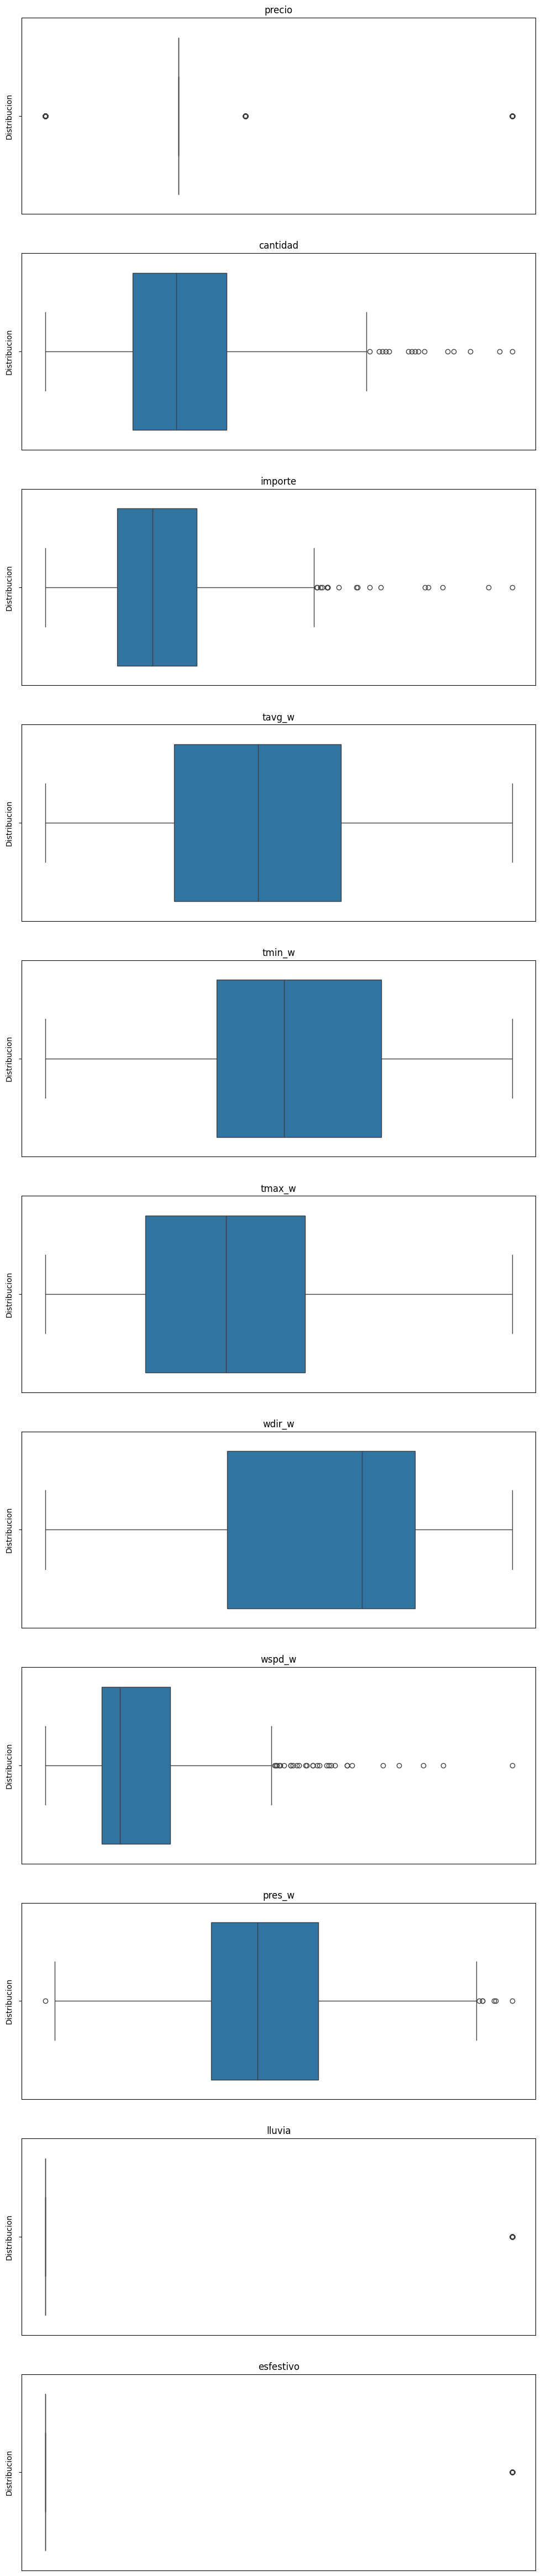

In [895]:
cols = numerical_features.columns
fig, axs = plt.subplots(len(cols),1,figsize=(12,60))

for col, ax in zip(cols, axs.ravel()):
  sns.boxplot(x=col, data=numerical_features, ax=ax)
  ax.set_ylabel("Distribucion")
  ax.get_xaxis().set_visible(False)
  ax.set_title(col)

In [896]:
correlacion_pearson = numerical_features.corr(method='pearson')
correlacion_pearson

precio  cantidad   importe    tavg_w    tmin_w    tmax_w  \
precio     1.000000  0.006432  0.318383 -0.369091 -0.409596 -0.295470   
cantidad   0.006432  1.000000  0.945402 -0.120318 -0.117515 -0.109183   
importe    0.318383  0.945402  1.000000 -0.232217 -0.240028 -0.200906   
tavg_w    -0.369091 -0.120318 -0.232217  1.000000  0.962221  0.957703   
tmin_w    -0.409596 -0.117515 -0.240028  0.962221  1.000000  0.864896   
tmax_w    -0.295470 -0.109183 -0.200906  0.957703  0.864896  1.000000   
wdir_w     0.253531  0.084350  0.157647 -0.240628 -0.342099 -0.095910   
wspd_w     0.071052  0.026240  0.050995 -0.064728 -0.079395 -0.090171   
pres_w     0.107309  0.039345  0.069417 -0.514094 -0.503277 -0.482521   
lluvia    -0.007140 -0.009645 -0.008240 -0.234766 -0.167304 -0.285871   
esfestivo  0.086179  0.178256  0.200811 -0.047973 -0.052479 -0.024616   

             wdir_w    wspd_w    pres_w    lluvia  esfestivo  
precio     0.253531  0.071052  0.107309 -0.007140   0.086179  
cantidad   0.084350  0.026240  0.039345 -0.009645   0.178256  
importe    0.157647  0.050995  0.069417 -0.008240   0.200811  
tavg_w    -0.240628 -0.064728 -0.514094 -0.234766  -0.047973  
tmin_w    -0.342099 -0.079395 -0.503277 -0.167304  -0.052479  
tmax_w    -0.095910 -0.090171 -0.482521 -0.285871  -0.024616  
wdir_w     1.000000  0.166494  0.025018  0.007922   0.057057  
wspd_w     0.166494  1.000000  0.105669 -0.090011  -0.057583  
pres_w     0.025018  0.105669  1.000000 -0.200355  -0.030665  
lluvia     0.007922 -0.090011 -0.200355  1.000000  -0.012048  
esfestivo  0.057057 -0.057583 -0.030665 -0.012048   1.000000

In [897]:
umbral = 0.5
columnas_altamente_correlacionadas = set()

for i in range(len(correlacion_pearson.columns)):
    for j in range(i):
        if abs(correlacion_pearson.iloc[i, j]) > umbral:
            colname = correlacion_pearson.columns[i]
            columnas_altamente_correlacionadas.add(colname)

In [898]:
columnas_altamente_correlacionadas

{'importe', 'pres_w', 'tmax_w', 'tmin_w'}

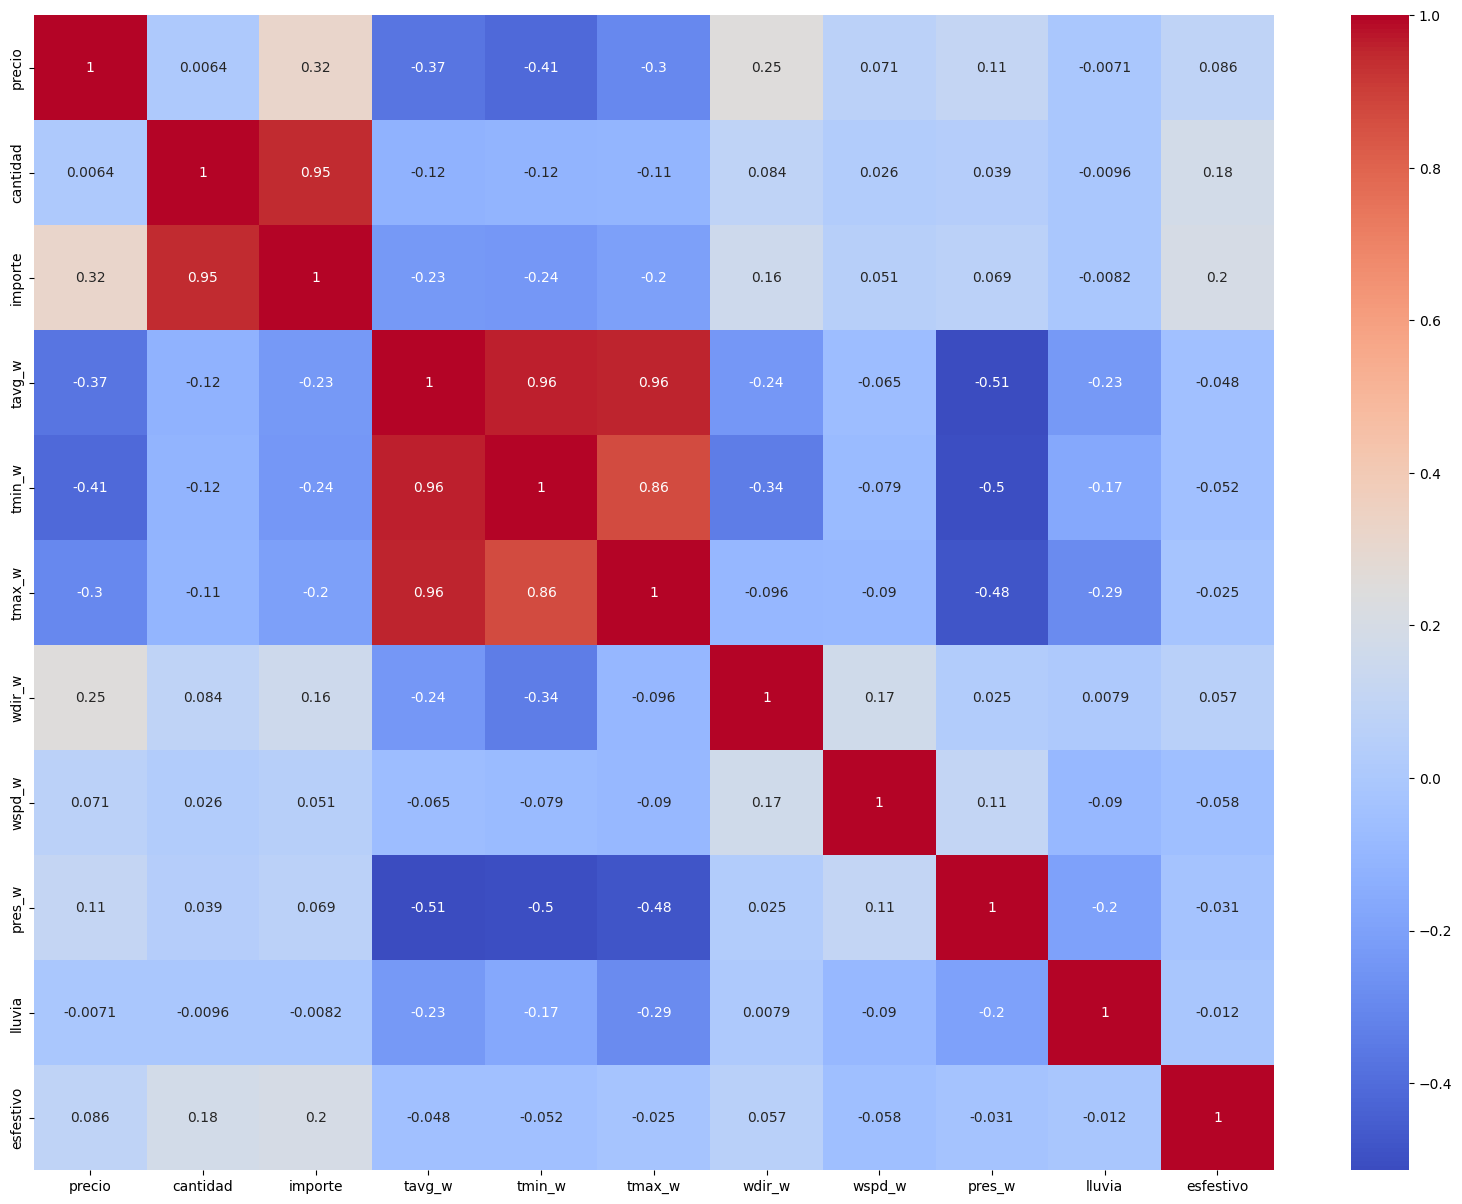

In [899]:
matriz_correlacion = numerical_features.corr()
plt.figure(figsize=(20, 15))

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm')
plt.show()

In [900]:
numerical_features.describe(include='all')

precio    cantidad      importe      tavg_w      tmin_w  \
count  730.000000  730.000000   730.000000  730.000000  730.000000   
mean     2.623619  244.516438   641.625022   19.348493   15.174795   
std      0.242359   68.740744   192.314267    5.402347    5.569168   
min      2.318000  114.000000   295.373998    7.300000    1.100000   
25%      2.591000  195.000000   505.244997   14.525000   10.800000   
50%      2.591000  235.500000   609.123001   19.250000   14.600000   
75%      2.591000  282.000000   738.107255   23.900000   20.100000   
max      3.273000  546.000000  1659.411041   33.500000   27.500000   

           tmax_w      wdir_w      wspd_w       pres_w      lluvia   esfestivo  
count  730.000000  728.000000  728.000000   728.000000  730.000000  730.000000  
mean    24.863836  216.730769   14.324176  1018.055632    0.126027    0.084932  
std      5.984177   73.509389    5.327863     5.178880    0.332108    0.278971  
min     13.300000   10.000000    6.000000  1004.400000    0.000000    0.000000  
25%     19.600000  144.750000   10.900000  1014.500000    0.000000    0.000000  
50%     24.650000  244.500000   12.500000  1017.300000    0.000000    0.000000  
75%     29.600000  284.000000   16.825000  1021.000000    0.000000    0.000000  
max     42.600000  356.000000   46.500000  1032.800000    1.000000    1.000000

## **PRE-PROCESSING**

### Initial Observation

In [901]:
itemsales = itemdata.copy()
itemsales.head()

fecha_venta          festivo  precio  cantidad     importe  tavg_w  tmin_w  \
0  2021-05-01  Día del Trabajo   2.318     402.0  931.835995    17.2    11.9   
1  2021-05-02  Día de la Madre   2.318     369.0  855.341996    16.3    10.8   
2  2021-05-03   Día de la Cruz   2.318     228.0  528.503994    15.3    12.7   
3  2021-05-04             None   2.318     237.0  549.365999    16.5    12.0   
4  2021-05-05             None   2.318     288.0  667.584000    16.7    12.3   

   tmax_w  wdir_w  wspd_w  pres_w  lluvia  esfestivo  
0    22.8   282.0    14.2  1014.0       0          1  
1    23.2   233.0    15.7  1015.9       0          1  
2    20.1   272.0     9.7  1017.7       1          1  
3    20.9   206.0    12.1  1018.0       0          0  
4    21.7   132.0    13.8  1016.5       0          0

In [902]:
itemsales.shape

(730, 13)

In [903]:
itemsales.dtypes

fecha_venta    datetime64[ns]
festivo                object
precio                float64
cantidad              float64
importe               float64
tavg_w                float64
tmin_w                float64
tmax_w                float64
wdir_w                float64
wspd_w                float64
pres_w                float64
lluvia                  int64
esfestivo               int64
dtype: object

### Gap Identification

In [904]:
itemsales.set_index("fecha_venta", inplace=True)

In [905]:
itemsales.head()

festivo  precio  cantidad     importe  tavg_w  tmin_w  \
fecha_venta                                                                  
2021-05-01   Día del Trabajo   2.318     402.0  931.835995    17.2    11.9   
2021-05-02   Día de la Madre   2.318     369.0  855.341996    16.3    10.8   
2021-05-03    Día de la Cruz   2.318     228.0  528.503994    15.3    12.7   
2021-05-04              None   2.318     237.0  549.365999    16.5    12.0   
2021-05-05              None   2.318     288.0  667.584000    16.7    12.3   

             tmax_w  wdir_w  wspd_w  pres_w  lluvia  esfestivo  
fecha_venta                                                     
2021-05-01     22.8   282.0    14.2  1014.0       0          1  
2021-05-02     23.2   233.0    15.7  1015.9       0          1  
2021-05-03     20.1   272.0     9.7  1017.7       1          1  
2021-05-04     20.9   206.0    12.1  1018.0       0          0  
2021-05-05     21.7   132.0    13.8  1016.5       0          0

In [906]:
itemsalescomplete = itemsales.resample("1D").last() # resample the data to have a daily frequency 
itemsales = itemsalescomplete.copy() # if there are multiple observations in a day, last() will select the last observation of that day
itemsales.head()

festivo  precio  cantidad     importe  tavg_w  tmin_w  \
fecha_venta                                                                  
2021-05-01   Día del Trabajo   2.318     402.0  931.835995    17.2    11.9   
2021-05-02   Día de la Madre   2.318     369.0  855.341996    16.3    10.8   
2021-05-03    Día de la Cruz   2.318     228.0  528.503994    15.3    12.7   
2021-05-04              None   2.318     237.0  549.365999    16.5    12.0   
2021-05-05              None   2.318     288.0  667.584000    16.7    12.3   

             tmax_w  wdir_w  wspd_w  pres_w  lluvia  esfestivo  
fecha_venta                                                     
2021-05-01     22.8   282.0    14.2  1014.0       0          1  
2021-05-02     23.2   233.0    15.7  1015.9       0          1  
2021-05-03     20.1   272.0     9.7  1017.7       1          1  
2021-05-04     20.9   206.0    12.1  1018.0       0          0  
2021-05-05     21.7   132.0    13.8  1016.5       0          0

### Null

In [907]:
itemsales.isnull().sum()

festivo      668
precio         0
cantidad       0
importe        0
tavg_w         0
tmin_w         0
tmax_w         0
wdir_w         2
wspd_w         2
pres_w         2
lluvia         0
esfestivo      0
dtype: int64

In [908]:
def mostCommonValueImputation(data, feature):
    valor_mas_comun = data[feature].mode()[0] # returns the modal values and keeps the first one.
    data[feature].fillna(valor_mas_comun, inplace=True)

In [909]:
mostCommonValueImputation(itemsales, 'wdir_w')
mostCommonValueImputation(itemsales, 'wspd_w')
mostCommonValueImputation(itemsales, 'pres_w')

/tmp/ipykernel_2129/2070125669.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





### Outliers

In [911]:
def modelOutlierDetection(data, nf, n = 20, drop = False):

  from sklearn.neighbors import LocalOutlierFactor

  clf = LocalOutlierFactor(n_neighbors=n)
  y_pred = clf.fit_predict(np.array(nf))

  data_clean = data.copy()
  data_clean["outliers"] = y_pred
  data_clean.drop(data_clean[data_clean["outliers"]<0].index, inplace=True)
  data_clean.drop("outliers", axis=1, inplace=True)
  # data_clean.reset_index(drop=True, inplace=True)
  print("Eliminated : {} instances.".format(len(data)-len(data_clean)))

  if drop:
    return  data_clean
  else:
    return data

In [912]:
numerical_features = itemsales.select_dtypes(include=[np.number])
itemsales = modelOutlierDetection(itemsales, numerical_features, n = 100, drop = True)

Eliminated : 18 instances.


### Converting the Problem to Supervised

In [913]:
itemsales.head()

festivo  precio  cantidad     importe  tavg_w  tmin_w  \
fecha_venta                                                                  
2021-05-01   Día del Trabajo   2.318     402.0  931.835995    17.2    11.9   
2021-05-02   Día de la Madre   2.318     369.0  855.341996    16.3    10.8   
2021-05-03    Día de la Cruz   2.318     228.0  528.503994    15.3    12.7   
2021-05-04              None   2.318     237.0  549.365999    16.5    12.0   
2021-05-05              None   2.318     288.0  667.584000    16.7    12.3   

             tmax_w  wdir_w  wspd_w  pres_w  lluvia  esfestivo  
fecha_venta                                                     
2021-05-01     22.8   282.0    14.2  1014.0       0          1  
2021-05-02     23.2   233.0    15.7  1015.9       0          1  
2021-05-03     20.1   272.0     9.7  1017.7       1          1  
2021-05-04     20.9   206.0    12.1  1018.0       0          0  
2021-05-05     21.7   132.0    13.8  1016.5       0          0

To choose the number of previous weeks, or previous days, it is necessary to see which previous moment is similar or identical to the current one, it is also necessary to make tests

In [914]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=itemdata["fecha_venta"], y=itemdata["cantidad"], mode='lines', name='Cantidad vendida'))

fig.update_layout(title='Amount Sold',
                  xaxis_title='Date',
                  yaxis_title='Amount',
                  showlegend=True)

fig.show()

- 05-09 to 05-30 (21 days) = 345 and 357
- 05-16 to 06-06 (21 days) = 324 and 318
- 08-29 to 09-19 (21 days) = 300 and 294

There seems to be a similar behaviour in the amount sold every 3 weeks and every 7 days backwards

In [915]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in_daily=1, n_in_weekly=1, n_out=1, dropnan=True): # to predict tomorrow's sales, n_out is 1

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # input sequence sales for days (t-n, ... t-1)
    for i in range(n_in_daily, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d day)' % (j+1, i)) for j in range(n_vars)]
    # input sequence sales for weeks (t-n, ... t-1)
    for i in range(n_in_weekly, 0, -1):
      cols.append(df.shift(i*7))
      names += [('var%d(t-%d week)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Se junta todo
    agg = concat(cols, axis=1)
    agg.columns = names
    # Eliminación de NaN
    if dropnan:
      agg.dropna(inplace=True)

    return agg

In [916]:
itemsalessupervised = series_to_supervised(pd.DataFrame(itemsales["cantidad"]), n_in_daily=7, n_in_weekly=3, n_out=1, dropnan = True)
itemsalessupervised.head(10)

var1(t-7 day)  var1(t-6 day)  var1(t-5 day)  var1(t-4 day)  \
fecha_venta                                                               
2021-05-22           216.0          324.0          177.0          216.0   
2021-05-23           324.0          177.0          216.0          162.0   
2021-05-24           177.0          216.0          162.0          177.0   
2021-05-25           216.0          162.0          177.0          189.0   
2021-05-26           162.0          177.0          189.0          306.0   
2021-05-27           177.0          189.0          306.0          453.0   
2021-05-28           189.0          306.0          453.0          141.0   
2021-05-29           306.0          453.0          141.0          210.0   
2021-05-30           453.0          141.0          210.0          243.0   
2021-05-31           141.0          210.0          243.0          171.0   

             var1(t-3 day)  var1(t-2 day)  var1(t-1 day)  var1(t-3 week)  \
fecha_venta                                                                
2021-05-22           162.0          177.0          189.0           402.0   
2021-05-23           177.0          189.0          306.0           369.0   
2021-05-24           189.0          306.0          453.0           228.0   
2021-05-25           306.0          453.0          141.0           237.0   
2021-05-26           453.0          141.0          210.0           288.0   
2021-05-27           141.0          210.0          243.0           144.0   
2021-05-28           210.0          243.0          171.0           252.0   
2021-05-29           243.0          171.0          234.0           276.0   
2021-05-30           171.0          234.0          309.0           345.0   
2021-05-31           234.0          309.0          357.0           174.0   

             var1(t-2 week)  var1(t-1 week)  var1(t)  
fecha_venta                                           
2021-05-22            276.0           216.0    306.0  
2021-05-23            345.0           324.0    453.0  
2021-05-24            174.0           177.0    141.0  
2021-05-25            174.0           216.0    210.0  
2021-05-26            180.0           162.0    243.0  
2021-05-27            228.0           177.0    171.0  
2021-05-28            216.0           189.0    234.0  
2021-05-29            216.0           306.0    309.0  
2021-05-30            324.0           453.0    357.0  
2021-05-31            177.0           141.0    240.0

### Exogenous Variables

In [917]:
itemsales.reset_index(inplace=True)
itemsalessupervised.reset_index(inplace=True)

In [918]:
itemsalessupervised.head(2)

fecha_venta  var1(t-7 day)  var1(t-6 day)  var1(t-5 day)  var1(t-4 day)  \
0  2021-05-22          216.0          324.0          177.0          216.0   
1  2021-05-23          324.0          177.0          216.0          162.0   

   var1(t-3 day)  var1(t-2 day)  var1(t-1 day)  var1(t-3 week)  \
0          162.0          177.0          189.0           402.0   
1          177.0          189.0          306.0           369.0   

   var1(t-2 week)  var1(t-1 week)  var1(t)  
0           276.0           216.0    306.0  
1           345.0           324.0    453.0

In [919]:
itemsales

fecha_venta          festivo  precio  cantidad      importe  tavg_w  \
0    2021-05-01  Día del Trabajo   2.318     402.0   931.835995    17.2   
1    2021-05-02  Día de la Madre   2.318     369.0   855.341996    16.3   
2    2021-05-03   Día de la Cruz   2.318     228.0   528.503994    15.3   
3    2021-05-04             None   2.318     237.0   549.365999    16.5   
4    2021-05-05             None   2.318     288.0   667.584000    16.7   
..          ...              ...     ...       ...          ...     ...   
707  2023-04-26             None   3.273     162.0   530.226013    20.3   
708  2023-04-27             None   3.273     216.0   706.968018    19.1   
709  2023-04-28             None   3.273     183.0   598.959015    20.8   
710  2023-04-29             None   3.273     249.0   814.977020    25.6   
711  2023-04-30             None   3.273     330.0  1080.090027    23.1   

     tmin_w  tmax_w  wdir_w  wspd_w  pres_w  lluvia  esfestivo  
0      11.9    22.8   282.0    14.2  1014.0       0          1  
1      10.8    23.2   233.0    15.7  1015.9       0          1  
2      12.7    20.1   272.0     9.7  1017.7       1          1  
3      12.0    20.9   206.0    12.1  1018.0       0          0  
4      12.3    21.7   132.0    13.8  1016.5       0          0  
..      ...     ...     ...     ...     ...     ...        ...  
707    15.5    26.0    93.0    10.7  1014.0       0          0  
708    15.0    24.5   122.0     9.9  1015.1       0          0  
709    16.6    26.7   144.0    14.3  1015.2       0          0  
710    18.7    34.3   289.0    16.9  1015.4       0          0  
711    18.2    27.7   239.0    15.3  1014.9       0          0  

[712 rows x 13 columns]

In [921]:
exovars = ["fecha_venta", "esfestivo", "lluvia", "tavg_w", "tmax_w"]
itemsalessupervised = itemsalessupervised.merge(itemsales[exovars], on="fecha_venta", how="inner")
itemsalessupervised.head()

fecha_venta  var1(t-7 day)  var1(t-6 day)  var1(t-5 day)  var1(t-4 day)  \
0  2021-05-22          216.0          324.0          177.0          216.0   
1  2021-05-23          324.0          177.0          216.0          162.0   
2  2021-05-24          177.0          216.0          162.0          177.0   
3  2021-05-25          216.0          162.0          177.0          189.0   
4  2021-05-26          162.0          177.0          189.0          306.0   

   var1(t-3 day)  var1(t-2 day)  var1(t-1 day)  var1(t-3 week)  \
0          162.0          177.0          189.0           402.0   
1          177.0          189.0          306.0           369.0   
2          189.0          306.0          453.0           228.0   
3          306.0          453.0          141.0           237.0   
4          453.0          141.0          210.0           288.0   

   var1(t-2 week)  var1(t-1 week)  var1(t)  esfestivo  lluvia  tavg_w  tmax_w  
0           276.0           216.0    306.0          0       0    23.6    32.5  
1           345.0           324.0    453.0          0       1    18.5    21.6  
2           174.0           177.0    141.0          0       0    20.1    27.2  
3           174.0           216.0    210.0          0       0    19.3    25.0  
4           180.0           162.0    243.0          0       0    19.8    23.0

In [922]:
itemsalessupervised["day"] = itemsalessupervised["fecha_venta"].dt.day
itemsalessupervised["dayofweek"] = itemsalessupervised["fecha_venta"].dt.dayofweek
itemsalessupervised["dayofweek"] = itemsalessupervised["dayofweek"]+1
itemsalessupervised["month"] = itemsalessupervised["fecha_venta"].dt.month
itemsalessupervised["year"] = itemsalessupervised["fecha_venta"].dt.year
itemsalessupervised["weekday"] = itemsalessupervised["dayofweek"]<6
itemsalessupervised

fecha_venta  var1(t-7 day)  var1(t-6 day)  var1(t-5 day)  var1(t-4 day)  \
0    2021-05-22          216.0          324.0          177.0          216.0   
1    2021-05-23          324.0          177.0          216.0          162.0   
2    2021-05-24          177.0          216.0          162.0          177.0   
3    2021-05-25          216.0          162.0          177.0          189.0   
4    2021-05-26          162.0          177.0          189.0          306.0   
..          ...            ...            ...            ...            ...   
686  2023-04-26          183.0          222.0          216.0          297.0   
687  2023-04-27          222.0          216.0          297.0          336.0   
688  2023-04-28          216.0          297.0          336.0          204.0   
689  2023-04-29          297.0          336.0          204.0          246.0   
690  2023-04-30          336.0          204.0          246.0          162.0   

     var1(t-3 day)  var1(t-2 day)  var1(t-1 day)  var1(t-3 week)  \
0            162.0          177.0          189.0           402.0   
1            177.0          189.0          306.0           369.0   
2            189.0          306.0          453.0           228.0   
3            306.0          453.0          141.0           237.0   
4            453.0          141.0          210.0           288.0   
..             ...            ...            ...             ...   
686          336.0          204.0          246.0           231.0   
687          204.0          246.0          162.0           327.0   
688          246.0          162.0          216.0           330.0   
689          162.0          216.0          183.0           267.0   
690          216.0          183.0          249.0           315.0   

     var1(t-2 week)  ...  var1(t)  esfestivo  lluvia  tavg_w  tmax_w  day  \
0             276.0  ...    306.0          0       0    23.6    32.5   22   
1             345.0  ...    453.0          0       1    18.5    21.6   23   
2             174.0  ...    141.0          0       0    20.1    27.2   24   
3             174.0  ...    210.0          0       0    19.3    25.0   25   
4             180.0  ...    243.0          0       0    19.8    23.0   26   
..              ...  ...      ...        ...     ...     ...     ...  ...   
686           183.0  ...    162.0          0       0    20.3    26.0   26   
687           138.0  ...    216.0          0       0    19.1    24.5   27   
688           204.0  ...    183.0          0       0    20.8    26.7   28   
689           276.0  ...    249.0          0       0    25.6    34.3   29   
690           333.0  ...    330.0          0       0    23.1    27.7   30   

     dayofweek  month  year  weekday  
0            6      5  2021    False  
1            7      5  2021    False  
2            1      5  2021     True  
3            2      5  2021     True  
4            3      5  2021     True  
..         ...    ...   ...      ...  
686          3      4  2023     True  
687          4      4  2023     True  
688          5      4  2023     True  
689          6      4  2023    False  
690          7      4  2023    False  

[691 rows x 21 columns]

### Encoding

In [924]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
itemsalessupervised["weekday"] = lb.fit_transform(itemsalessupervised["weekday"])
itemsalessupervised

fecha_venta  var1(t-7 day)  var1(t-6 day)  var1(t-5 day)  var1(t-4 day)  \
0    2021-05-22          216.0          324.0          177.0          216.0   
1    2021-05-23          324.0          177.0          216.0          162.0   
2    2021-05-24          177.0          216.0          162.0          177.0   
3    2021-05-25          216.0          162.0          177.0          189.0   
4    2021-05-26          162.0          177.0          189.0          306.0   
..          ...            ...            ...            ...            ...   
686  2023-04-26          183.0          222.0          216.0          297.0   
687  2023-04-27          222.0          216.0          297.0          336.0   
688  2023-04-28          216.0          297.0          336.0          204.0   
689  2023-04-29          297.0          336.0          204.0          246.0   
690  2023-04-30          336.0          204.0          246.0          162.0   

     var1(t-3 day)  var1(t-2 day)  var1(t-1 day)  var1(t-3 week)  \
0            162.0          177.0          189.0           402.0   
1            177.0          189.0          306.0           369.0   
2            189.0          306.0          453.0           228.0   
3            306.0          453.0          141.0           237.0   
4            453.0          141.0          210.0           288.0   
..             ...            ...            ...             ...   
686          336.0          204.0          246.0           231.0   
687          204.0          246.0          162.0           327.0   
688          246.0          162.0          216.0           330.0   
689          162.0          216.0          183.0           267.0   
690          216.0          183.0          249.0           315.0   

     var1(t-2 week)  ...  var1(t)  esfestivo  lluvia  tavg_w  tmax_w  day  \
0             276.0  ...    306.0          0       0    23.6    32.5   22   
1             345.0  ...    453.0          0       1    18.5    21.6   23   
2             174.0  ...    141.0          0       0    20.1    27.2   24   
3             174.0  ...    210.0          0       0    19.3    25.0   25   
4             180.0  ...    243.0          0       0    19.8    23.0   26   
..              ...  ...      ...        ...     ...     ...     ...  ...   
686           183.0  ...    162.0          0       0    20.3    26.0   26   
687           138.0  ...    216.0          0       0    19.1    24.5   27   
688           204.0  ...    183.0          0       0    20.8    26.7   28   
689           276.0  ...    249.0          0       0    25.6    34.3   29   
690           333.0  ...    330.0          0       0    23.1    27.7   30   

     dayofweek  month  year  weekday  
0            6      5  2021        0  
1            7      5  2021        0  
2            1      5  2021        1  
3            2      5  2021        1  
4            3      5  2021        1  
..         ...    ...   ...      ...  
686          3      4  2023        1  
687          4      4  2023        1  
688          5      4  2023        1  
689          6      4  2023        0  
690          7      4  2023        0  

[691 rows x 21 columns]

In [929]:
print("datos desde", itemsalessupervised["fecha_venta"].min())
print("datos hasta", itemsalessupervised["fecha_venta"].max())

datos desde 2021-05-22 00:00:00
datos hasta 2023-04-30 00:00:00


- from 22 May 2021 to 7 April 2023 is training and evaluation
- from 7 April 2023 to 30 April 2023 is test

In [930]:
sales_supervised_train = itemsalessupervised[itemsalessupervised['fecha_venta'] <= '2023-04-06']
sales_supervised_test = itemsalessupervised[itemsalessupervised['fecha_venta'] > '2023-04-06']

In [931]:
print("datos desde", sales_supervised_train["fecha_venta"].min())
print("datos hasta", sales_supervised_train["fecha_venta"].max())

datos desde 2021-05-22 00:00:00
datos hasta 2023-04-06 00:00:00


In [932]:
print("datos desde", sales_supervised_test["fecha_venta"].min())
print("datos hasta", sales_supervised_test["fecha_venta"].max())

datos desde 2023-04-07 00:00:00
datos hasta 2023-04-30 00:00:00


In [934]:
sales_supervised_train.head()

fecha_venta  var1(t-7 day)  var1(t-6 day)  var1(t-5 day)  var1(t-4 day)  \
0  2021-05-22          216.0          324.0          177.0          216.0   
1  2021-05-23          324.0          177.0          216.0          162.0   
2  2021-05-24          177.0          216.0          162.0          177.0   
3  2021-05-25          216.0          162.0          177.0          189.0   
4  2021-05-26          162.0          177.0          189.0          306.0   

   var1(t-3 day)  var1(t-2 day)  var1(t-1 day)  var1(t-3 week)  \
0          162.0          177.0          189.0           402.0   
1          177.0          189.0          306.0           369.0   
2          189.0          306.0          453.0           228.0   
3          306.0          453.0          141.0           237.0   
4          453.0          141.0          210.0           288.0   

   var1(t-2 week)  ...  var1(t)  esfestivo  lluvia  tavg_w  tmax_w  day  \
0           276.0  ...    306.0          0       0    23.6    32.5   22   
1           345.0  ...    453.0          0       1    18.5    21.6   23   
2           174.0  ...    141.0          0       0    20.1    27.2   24   
3           174.0  ...    210.0          0       0    19.3    25.0   25   
4           180.0  ...    243.0          0       0    19.8    23.0   26   

   dayofweek  month  year  weekday  
0          6      5  2021        0  
1          7      5  2021        0  
2          1      5  2021        1  
3          2      5  2021        1  
4          3      5  2021        1  

[5 rows x 21 columns]

In [935]:
sales_supervised_test.head()

fecha_venta  var1(t-7 day)  var1(t-6 day)  var1(t-5 day)  var1(t-4 day)  \
667  2023-04-07          216.0          210.0          315.0          210.0   
668  2023-04-08          210.0          315.0          210.0          204.0   
669  2023-04-09          315.0          210.0          204.0          231.0   
670  2023-04-10          210.0          204.0          231.0          327.0   
671  2023-04-11          204.0          231.0          327.0          330.0   

     var1(t-3 day)  var1(t-2 day)  var1(t-1 day)  var1(t-3 week)  \
667          204.0          231.0          327.0           255.0   
668          231.0          327.0          330.0           177.0   
669          327.0          330.0          267.0           327.0   
670          330.0          267.0          315.0           153.0   
671          267.0          315.0          213.0           216.0   

     var1(t-2 week)  ...  var1(t)  esfestivo  lluvia  tavg_w  tmax_w  day  \
667           150.0  ...    330.0          1       0    13.9    19.8    7   
668           309.0  ...    267.0          1       0    14.1    21.5    8   
669           321.0  ...    315.0          1       0    14.9    20.6    9   
670           183.0  ...    213.0          0       0    22.8    33.7   10   
671           156.0  ...    153.0          0       0    17.8    22.6   11   

     dayofweek  month  year  weekday  
667          5      4  2023        1  
668          6      4  2023        0  
669          7      4  2023        0  
670          1      4  2023        1  
671          2      4  2023        1  

[5 rows x 21 columns]

In [936]:
sales_supervised_train.to_csv('sales_supervised_train.csv', index=False)
sales_supervised_test.to_csv('sales_supervised_test.csv', index=False)

------------------------------